# What are the most serious meteorological disasters in the United States?

![A photo of a tornado](data/images/tornado.jpg)

## Introduction

**Business Context.** While natural *events* often cannot be avoided, the risks they present can be managed, either by mitigation, avoidance, or insurance, in order to prevent them from becoming natural *disasters*. The consultancy firm you work for has been hired by an independent advocacy group that wants to conduct an analysis of the US emergency management system of preparedness, protection, mitigation, response, and recovery, with the purpose of proposing legislative reforms to make it more effective and financially efficient. Their ultimate goal is to help increase the government's ability to prevent disasters from happening and reduce the negative impact of those that cannot be completely avoided.

**Business Problem.** Your client would like to know which storm event types are more likely to become disasters, and in which locations, as measured by the number of deaths, injuries, and economic damage they cause. Additionally, they would like to conduct a preliminary assessment of whether the [Post-Katrina Emergency Management Reform Act of 2006](https://www.congress.gov/bill/109th-congress/senate-bill/3721) had any impact on the severity of the disasters that occurred after the bill was signed. This Act centralized the US emergency management under the coordination of the Federal Emergency Management Agency (FEMA) as a response to the enormous human and material losses that were caused by Hurricane Katrina in August 2005.

**Analytical Context.** You have been provided with a compressed GZIP file of storm events from 1970 to 2020 as recorded by the US [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/stormevents/ftp.jsp). You can check the [documentation](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Bulk-csv-Format.pdf) for more information.

In [2]:
! pip install -r requirements.txt

In [20]:
# Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import pingouin as pg

## Loading in the dataset

Let's load in the dataset. We add the `parse_dates` argument to tell pandas which columns should be interpreted as dates.

In [21]:
df = pd.read_csv("data/dataset.csv.gz", parse_dates=["BEGIN_DATE_TIME", "END_DATE_TIME"])
df.head()

,EPISODE_ID,EVENT_ID,STATE,EVENT_TYPE,BEGIN_DATE_TIME,BEGIN_YEAR,CZ_TIMEZONE,END_DATE_TIME,TOR_F_SCALE,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TOTAL_DEATHS,TOTAL_INJURIES,TOTAL_DAMAGE_DEFLATED
0,NaN,9987739,COLORADO,hail,1983-07-22 16:40:00,1983.0,CST,1983-07-22 16:40:00,NaN,NaN,NaN,39.72,-104.60,NaN,NaN,0,0,0.0
1,NaN,9987740,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.87,NaN,NaN,0,0,0.0
2,NaN,9987741,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.93,NaN,NaN,0,0,0.0
3,NaN,9987735,COLORADO,hail,1983-07-22 16:20:00,1983.0,CST,1983-07-22 16:20:00,NaN,NaN,NaN,39.73,-104.85,NaN,NaN,0,0,0.0
4,NaN,9987736,COLORADO,hail,1983-07-22 16:25:00,1983.0,CST,1983-07-22 16:25:00,NaN,NaN,NaN,39.72,-104.82,NaN,NaN,0,0,0.0


In [3]:
df["EVENT_TYPE"].value_counts()

thunderstorm wind    710504
hail                 560023
flash flood          136863
winter storm         113409
high wind            107840
                      ...  
hail icy roads            2
hail flooding             2
marine lightning          1
high snow                 1
other                     1
Name: EVENT_TYPE, Length: 62, dtype: int64

###### Here is a description of the imported columns:

1. **EPISODE_ID**: The storm episode ID. A single episode can contain multiple events
2. **EVENT_ID**: This is the ID of the actual storm as such. Several storms can be grouped into an episode
3. **STATE**: The state or region where the event occurred
4. **EVENT_TYPE**: The type of the event
5. **BEGIN_DATE_TIME**: The date and time when the event started. Times and dates are in LST (Local Solar Time), which means that they reflect the local time, not a coordinated time
6. **BEGIN_YEAR**: The year in which the event begun
7. **CZ_TIMEZONE**: The timezone of the place where the event occurred
8. **END_DATE_TIME**: The date and time when the event ended. Times and dates are in LST (Local Solar Time), which means that they reflect the local time, not a coordinated time
9. **TOR_F_SCALE**: The [enhanced Fujita scale](https://en.wikipedia.org/wiki/Enhanced_Fujita_scale) (highest recorded value). This scale measures the strength of a tornado based on the amount of damage that it caused. A level of `EF0` means "light damage" (wind speeds of 40 - 72 mph), and a level of `EF5` means "incredible damage" (261 - 318 mph). `EFU` means "Unknown"
10. **BEGIN_LOCATION**: The name of the city or village where the event started
11. **END_LOCATION**: The name of the city or village where the event ended
12. **BEGIN_LAT**: The latitude of the place where the event begun
13. **BEGIN_LON**: The longitude of the place where the event begun
14. **END_LAT**: The latitude of the place where the event ended
15. **END_LON**: The longitude of the place where the event ended
16. **TOTAL_DEATHS**: Deaths directly or indirectly attributable to the event
17. **TOTAL_INJURIES**: Injuries directly or indirectly attributable to the event
18.  **TOTAL_DAMAGE_DEFLATED**: Estimated damage to property and crops in dollars. These dollars are "real" dollars, which means that the damages for all the years have been converted ([deflated](https://faculty.fuqua.duke.edu/~rnau/Decision411_2007/411infla.htm)) to the value they would have had in 1982-84. This was done to make the damages comparable across years, since dollars [change purchasing power every year](https://www.insider.com/fast-food-burgers-cost-every-year-2018-9) due to inflation. The deflation was done using the Bureau of Labor Statistics Urban Consumer Price Index, whose base period is 1982-84.

## Exploratory data analysis (EDA)

### Exercise 1

A good first step in EDA is visualizing the univariate distributions of each feature in the dataset. Here's a numbered list of the columns:

| Number 	| Column name 	|
|-	|-	|
| 1 	| STATE 	|
| 2 	| EVENT_TYPE 	|
| 3 	| BEGIN_DATE_TIME 	|
| 4 	| BEGIN_YEAR 	|
| 5 	| CZ_TIMEZONE 	|
| 6 	| END_DATE_TIME 	|
| 7 	| TOR_F_SCALE 	|
| 8 	| BEGIN_LOCATION 	|
| 9 	| END_LOCATION 	|
| 10 	| BEGIN_LAT 	|
| 11 	| BEGIN_LON 	|
| 12 	| END_LAT 	|
| 13 	| END_LON 	|
| 14 	| TOTAL_DEATHS 	|
| 15 	| TOTAL_INJURIES 	|
| 16 	| TOTAL_DAMAGE_DEFLATED 	|

Modify the function below to indicate which visualizations are well-suited to exploring the univariate distributions of each one of the columns. Append the number of the feature to the corresponding list.

Some things to keep in mind:

1. Please provide visualization choices for *each* of the features.
2. If you believe that a visualization doesn't apply to any of the columns, simply leave it as an empty list.
3. A single feature can be added to more than one visualization's corresponding list.

In [4]:
def visualization_choice():
    """
    Returns the answer to exercise 1.
    
    Example:
    Let's say you want to add features 1 and 16 to `barplot`. Just
    add the numbers to the list. In other words, the line should
    be `barplot = [1,16]`.
    """
    
     
    # HISTOGRAMS
    histogram = [3,4,6,10,11,12,13,14,15,16]
    
    # BAR PLOTS
    barplot = [1,2,3,4,5,6,7,8,9]
    
    # BOX PLOTS
    boxplot = [3,4,10,11,12,13,14,15,16]
    
    # GEO HEAT MAP
    geoheatmap = []
    
    # LINE PLOT
    lineplot = [3,6]
    
    # DENSITY PLOT
    densityplot = [3,6,10,11,12,13,14,15,16]
    

    
    visualization_choices = {
        "histogram":histogram,
        "barplot":barplot,
        "boxplot":boxplot,
        "geoheatmap":geoheatmap,
        "lineplot":lineplot,
        "densityplot":densityplot,
    }
    
    return visualization_choices

visualization_choice()

{'histogram': [4, 14, 15, 16],
 'barplot': [1, 2, 4, 5, 7, 14, 15, 16],
 'boxplot': [14, 15, 16],
 'geoheatmap': [8, 9, 10, 11, 12, 13],
 'lineplot': [3, 4, 6, 14, 15, 16],
 'densityplot': [4, 14, 15, 16]}

### Exercise 2

#### 2.1

As discussed in the regular cases, it is important to compute summary statistics for each feature. We know that the damage caused by natural disasters usually has a distribution that is very skewed to the right. Which TWO of the following summary statistics would be MOST useful to confirm that this is the case for the `TOTAL_DEATHS`, `TOTAL_INJURIES`, and `TOTAL_DAMAGE_DEFLATED` columns?
<ul>
A. Count<br>
B. Mean<br>
C. Minimum<br>
D. Maximum<br>
E. 25th percentile<br>
F. Median<br>
G. 75th percentile<br>
</ul>

In [5]:
def summary_choice():
    """
    Returns the two options you chose.
    
    Uncomment the lines that correspond to your choice.
    """
    
    A = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].count()
    B = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].mean()
    C = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].min()
    D = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].max()
    E = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].quantile(0.25)
    F = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].quantile(0.5)
    G = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].quantile(0.75)
    
    
    answer = {}
    #answer["A"] = A
    answer["B"] = B
    #answer["C"] = C
    #answer["D"] = D
    #answer["E"] = E
    answer["F"] = F
    #answer["G"] = G
    
   
    
    return answer

#### 2.2

Inspect the tables of the two summary statistics you chose. What can you interpret from your results?

**Note:** In this and all similar subsequent exercises, please answer in the cell that is immediately below this one (if you write in the same cell as the question, your answer will not be recorded).


In [6]:
B = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].mean()
print(B)

                       TOTAL_DEATHS  TOTAL_INJURIES  TOTAL_DAMAGE_DEFLATED
EVENT_TYPE                                                                
astronomical low tide      0.001139        0.027335           3.456014e+00
avalanche                  0.554622        0.384454           3.341661e+03
blizzard                   0.012670        0.044252           4.520701e+04
coastal flood              0.013320        0.005567           3.068489e+06
cold wind chill            0.039958        0.026992           7.588848e+04
...                             ...             ...                    ...
volcanic ashfall           0.000000        0.000000           2.031125e+03
waterspout                 0.001013        0.000633           5.209241e+02
wildfire                   0.056926        0.368173           1.855717e+06
winter storm               0.006984        0.037528           1.648499e+04
winter weather             0.014354        0.087342           7.879550e+02

[62 rows x 3 columns]


In [7]:
F = df.groupby(["EVENT_TYPE"])[["TOTAL_DEATHS", "TOTAL_INJURIES", "TOTAL_DAMAGE_DEFLATED"]].quantile(0.5)
print(F)

                       TOTAL_DEATHS  TOTAL_INJURIES  TOTAL_DAMAGE_DEFLATED
EVENT_TYPE                                                                
astronomical low tide           0.0             0.0                    0.0
avalanche                       0.0             0.0                    0.0
blizzard                        0.0             0.0                    0.0
coastal flood                   0.0             0.0                    0.0
cold wind chill                 0.0             0.0                    0.0
...                             ...             ...                    ...
volcanic ashfall                0.0             0.0                    0.0
waterspout                      0.0             0.0                    0.0
wildfire                        0.0             0.0                    0.0
winter storm                    0.0             0.0                    0.0
winter weather                  0.0             0.0                    0.0

[62 rows x 3 columns]


**Your answer here**.

Both deaths and injuries are very right skewed. This indicates most storm events don't cause deaths or injuries.
The median values (F) are less than the mean values (B), which indicates that the distribution of data is skewed to the right

### Exercise 3


Let's now look at some bivariate distributions. This is a pair plot of some of the numeric variables of the dataset:

![Pairplot](data/images/pairplot.png)

What useful insights can you gather from the plot?


The beginning and ending latitude are higher in more recent years. 
There is also more total damage in more recent years compared to the mid 1990s. I believe this is likely due to climate change causing changes in storm location, severity, and how often they occur.


### Exercise 4

Some storm events have a wider risk area than others, which can make them more worthy of attention for authorities. Which of these visualization strategies could be useful to find patterns related to the size of the risk area around storm events? Append the letters of all options that apply to the `answer` list in the function below.

&nbsp;&nbsp;&nbsp;&nbsp; A. A scatter plot of `BEGIN_LAT` vs. `END_LAT`<br>
&nbsp;&nbsp;&nbsp;&nbsp; B. A scatter plot of `BEGIN_LON` vs. `END_LON`<br>
&nbsp;&nbsp;&nbsp;&nbsp; C. A geographic heat map of the count of `BEGIN_LOCATION` per event<br>
&nbsp;&nbsp;&nbsp;&nbsp; D. A grouped geographic scatterplot of those events whose `BEGIN_LOCATION` and `END_LOCATION` do not coincide (in one color) vs. those in which they do coincide (in another color). (A geographic scatterplot is a scatterplot layered on top of a map, with the $x$- and $y$-coordinates being the longitude and the latitude of each point - see some examples [here](https://plotly.com/python/scatter-plots-on-maps/).)

In [8]:
def geo_spread():
    """
    Returns the selected answer
    """
    
    answer = []
    
    # YOUR CODE HERE
    
    
    # answer.append(["A"])
    # answer.append(["B"])
    answer.append(["C"])
    answer.append(["D"])
    
    return answer

### Exercise 5

#### 5.1

Plot one (or more) of your choices from the previous exercise.

In [9]:
# YOUR CODE HERE

df=df.dropna()
df["BEGIN_LON"]=df["BEGIN_LON"].astype(float)
df["BEGIN_LAT"]=df["BEGIN_LAT"].astype(float)

my_zip=zip(df["BEGIN_LAT"],df["BEGIN_LON"])
list_of_my_zip=list(my_zip)
list_of_my_zip[0:15]


[(39.08, -77.32),
 (39.628, -76.182),
 (42.4918, -96.59),
 (42.3941, -96.7337),
 (40.694, -80.943),
 (46.43, -97.03),
 (46.65, -96.42),
 (38.9745, -99.1969),
 (32.3331, -93.7995),
 (37.5055, -101.88),
 (37.4688, -101.9445),
 (34.49, -82.79),
 (40.0656, -101.4581),
 (33.943000000000005, -96.73100000000001),
 (39.5158, -89.1932)]

In [10]:
from folium.plugins import HeatMap

In [11]:
location=[37,-95]
folium_map=folium.Map(location=location, zoom_start=4, titles="Map")

heatmap_layer = HeatMap(list_of_my_zip,
                   min_opacity=0.2,
                   radius=8,
                   blur=6, 
                 )


folium_map.add_child(heatmap_layer)
folium_map

#### 5.2

Write down your findings in the cell below.


**Your answer here.**

The geographical location with the highest counts are in the West(Kansas,Oklahoma, Ohio), and the South (Arkansas,Louisiana,Mississippi, Florida), and the east coast (south of NYC)

### Exercise 6

In the context of natural disaster management, risk is defined as the probability of an event happening times the hazard that its occurrence may pose (that is, the potential damages that could happen if the event takes place):

$$Risk = Probability \times Hazard$$

The estimation of risk is part of what is sometimes called "risk assessment". 

Since we are still in the exploratory phase, we do not want to start modeling right away. We would like to rely on plots and visualizations instead.

Describe a data visualization strategy that includes metrics and plots of different kinds to estimate:

1. which storm types are most likely to happen in a given month;
2. how large the economic damages caused by the storms would be; and
3. in which locations the storms are most likely to happen


**Your answer here.**

1. I would create a graph for each month using the BEGIN_DATE and END_DATE columns and make a bar graph of the counts for each EVENT_TYPE. The event types that correspond to the highest bars are most likely to happen in that particular month.


2. I would create a bar graph measuring the TOTAL_DAMAGE_DEFLATED for each EVENT_TYPE. I would also calculate the sum and mean for the TOTAL_DAMAGE_DEFLATED for each EVENT_TYPE in order to have a better understanding of the total damage for each event type and also the average amount of damage for each event in the corresponding event type.

3. I would create a heat map mapping out the BEGIN_LOCATION and END_LOCATION with the areas on the map with more events being shaded in one color as opposed to the areas with less events.



### Exercise 7

Code at least one of the visualizations you proposed in the previous exercise.

In [30]:
df = pd.read_csv("data/dataset.csv.gz", parse_dates=["BEGIN_DATE_TIME", "END_DATE_TIME"])
df.head()

,EPISODE_ID,EVENT_ID,STATE,EVENT_TYPE,BEGIN_DATE_TIME,BEGIN_YEAR,CZ_TIMEZONE,END_DATE_TIME,TOR_F_SCALE,BEGIN_LOCATION,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,TOTAL_DEATHS,TOTAL_INJURIES,TOTAL_DAMAGE_DEFLATED
0,NaN,9987739,COLORADO,hail,1983-07-22 16:40:00,1983.0,CST,1983-07-22 16:40:00,NaN,NaN,NaN,39.72,-104.60,NaN,NaN,0,0,0.0
1,NaN,9987740,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.87,NaN,NaN,0,0,0.0
2,NaN,9987741,COLORADO,hail,1983-07-22 16:45:00,1983.0,CST,1983-07-22 16:45:00,NaN,NaN,NaN,39.73,-104.93,NaN,NaN,0,0,0.0
3,NaN,9987735,COLORADO,hail,1983-07-22 16:20:00,1983.0,CST,1983-07-22 16:20:00,NaN,NaN,NaN,39.73,-104.85,NaN,NaN,0,0,0.0
4,NaN,9987736,COLORADO,hail,1983-07-22 16:25:00,1983.0,CST,1983-07-22 16:25:00,NaN,NaN,NaN,39.72,-104.82,NaN,NaN,0,0,0.0


In [31]:
df.head(10)
df["EVENT_TYPE"].value_counts()

thunderstorm wind             710504
hail                          560023
flash flood                   136863
winter storm                  113409
high wind                     107840
                               ...  
tornadoes, tstm wind, hail         2
hail icy roads                     2
other                              1
marine lightning                   1
high snow                          1
Name: EVENT_TYPE, Length: 62, dtype: int64

<AxesSubplot:xlabel='EVENT_TYPE'>

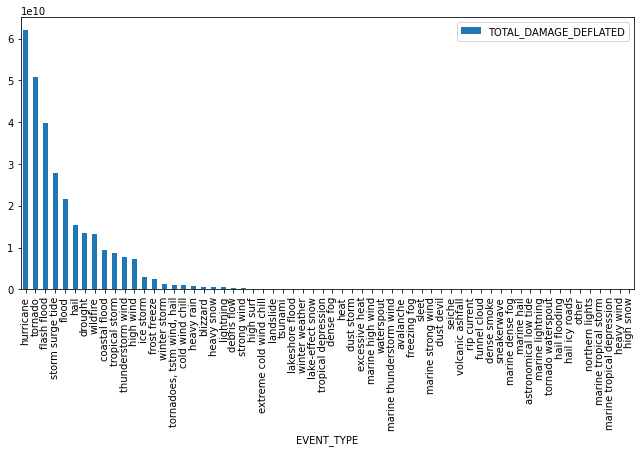

In [38]:
df_graph=df.groupby(["EVENT_TYPE"])["TOTAL_DAMAGE_DEFLATED"].sum().reset_index(name="TOTAL_DAMAGE_DEFLATED")

df_graph.sort_values(by="TOTAL_DAMAGE_DEFLATED", ascending=False).plot.bar(x="EVENT_TYPE", y="TOTAL_DAMAGE_DEFLATED", figsize=(11,5))



## The Post-Katrina Emergency Management Reform Act of 2006

### Exercise 8 (hard)

#### 8.1

Conduct a hypothesis test for each event type to assess whether there is a difference in average total damage when comparing disasters that happened before the reform to those that happened after. Keep only the event types for which you found a significant difference (using a significance threshold of $\alpha=0.01$). Since it is likely that not all events that have happened in the US are present in this dataset, we can interpret the data as being a sample (conducting hypothesis tests on population data would not make sense).

**Note:** If an event type does not have associated events either before or after the Act, ignore it and don't add it to the dictionary (since a $t$ - test won't be possible). Do not apply the Bonferroni correction in this exercise.

<details>
    <summary markdown="span">
        <br>Click here for a <b>Hint</b>
    </summary>
    <blockquote>
        Use the <a href="https://pingouin-stats.org/generated/pingouin.ttest.html"><code>.ttest()</code></a> function from the <code>pingouin</code> library.
    </blockquote>
</details>

In [22]:
df["POST_ACT"] = df["BEGIN_YEAR"] > 2006

def test_differences(df):
    """
    Conducts a t-test on TOTAL_DAMAGES comparing events
    that happened in 2006 or before with events that
    happenned after that year.
    
    Inputs:
    `df`: A pandas DataFrame
    
    Outputs:
    `p_values_signif`: A Python dictionary in which the keys are the event type
    and the values are the significant p-values that resulted from the t-test (alpha
    of 0.01)
    
    Note: If an event type does not have associated events either before or
    after the act, ignore it and don't add it to the dictionary (since a t-test
    won't be possible)
    """
      
    pre_dam = df[df["POST_ACT"]==False][["EVENT_TYPE", "TOTAL_DAMAGE_DEFLATED"]].dropna(how="any")
    post_dam = df[df["POST_ACT"]==True][["EVENT_TYPE", "TOTAL_DAMAGE_DEFLATED"]].dropna(how="any")
    
    # YOUR CODE HERE
    
    uni_pre_dam=pre_dam["EVENT_TYPE"].unique()
    uni_post_dam=post_dam["EVENT_TYPE"].unique()
    set_list_pre_dam=set(uni_pre_dam)
    set_list_post_dam=set(uni_post_dam)
    
    storms=(set_list_pre_dam & set_list_post_dam)
    list_storms=list(storms)
    
    p_values_signif={}
    
    for item in list_storms:
        pre_damage=pre_dam[pre_dam["EVENT_TYPE"]==str(item)].TOTAL_DAMAGE_DEFLATED
        post_damage=post_dam[post_dam["EVENT_TYPE"]==str(item)].TOTAL_DAMAGE_DEFLATED
        p = pg.ttest(pre_damage, post_damage, confidence = 0.01).round(5)
        ALPHA=0.01
        p=float(p.loc[:,'p-val'])
        sig=bool(p<.01)
        if sig:
            p_values_signif[str(item)]=p
            
  
    
    return p_values_signif

In [23]:
test_differences(df)

{'excessive heat': 0.0,
 'flash flood': 0.00175,
 'tornado': 0.00247,
 'heavy snow': 0.0027,
 'heavy rain': 0.00157,
 'sleet': 6e-05,
 'drought': 0.0,
 'lake-effect snow': 0.0,
 'high surf': 0.00293}

#### 8.2

For these significant event types, plot their total deflated damages as box plots, comparing the pre-Act events with the post-Act events.

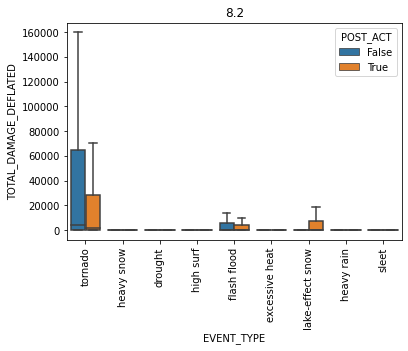

<Figure size 432x288 with 0 Axes>

In [30]:
df1=pd.DataFrame(df['POST_ACT'])
df2=pd.DataFrame(df['EVENT_TYPE'])

cdf=pd.concat([df1,df2])
events_list=p_values_signif
mdf=df[["EVENT_TYPE","POST_ACT","TOTAL_DAMAGE_DEFLATED"]][df["EVENT_TYPE"].isin(events_list)]

events_list=mdf[["EVENT_TYPE","TOTAL_DAMAGE_DEFLATED"]]

sns.boxplot(x="EVENT_TYPE",y="TOTAL_DAMAGE_DEFLATED",hue="POST_ACT",data=mdf,showfliers=False)
plt.xticks(rotation=90)
plt.title("8.2")
plt.show()
plt.clf()



#### 8.3

What conclusions can you draw from the hypothesis tests you have just conducted, and why?


**Your answer here.**

There was more damage before the reform compared to after. This is particularly apparant with tornadoes and flash floods. The exception to this is lake-effect snow. This is likely due to climate change causing snow to melt at a higher degree in most recent years

## Testing cells

In [9]:
# Ex. 1
ex1 = visualization_choice()
c = set()
for key in ex1.keys():
    for i in ex1[key]:
        c.add(i)
assert len(c - {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}) == 0, "Ex. 1 - It seems you included a number that is not one of the column IDs!"
assert c == {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}, "Ex. 1 - It seems you did not add a visualization for all the columns!"
print("Exercise 1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!")

Exercise 1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!


In [12]:
# Ex. 2
ans_2 = summary_choice().keys()
assert len(ans_2) == 2, "Ex. 2.1 - Please choose exactly two summary statistics!"
print("Exercise 2.1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!")

Exercise 2.1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!


In [22]:
# Ex. 4
assert len(geo_spread()) > 0, "Ex. 4 - Please choose at least one option!"
print("Exercise 4 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!")

Exercise 4 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!


In [25]:
# Ex. 8.1
import warnings
warnings.filterwarnings("ignore")
p_values_signif = test_differences(df)
assert len(p_values_signif)==9, "Ex. 8.1 - Your output seems to have the wrong number of elements! Remember to use an alpha of 0.01 (not 0.05)"
s = 0
for key in p_values_signif.keys():
    s = s+p_values_signif[key]
assert s < 0.015, "Ex. 8.1 - Your p-values are apparently too large! Remember to use an alpha of 0.01 (not 0.05)"
print("Exercise 8.1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!")
print("Exercise 8.1 looks correct!")

Exercise 8.1 passed our preliminary screening. You will get the final grade after your TA has reviewed your submission!
Exercise 8.1 looks correct!


## Attribution

"Storm Events Database", 20 Nov 2020, National Oceanic and Atmospheric Administration, Licensed under the [Freedom of Information Act](https://www.noaa.gov/organization/information-technology/freedom-of-information-act), https://www.ncdc.noaa.gov/stormevents/ftp.jsp

"F5 tornado Elie Manitoba 2007", 22 Jun 2017, Justin Hobson, Creative Commons Attribution-Share Alike 3.0 Unported license, https://commons.wikimedia.org/wiki/File:F5_tornado_Elie_Manitoba_2007.jpg

"Historical Consumer Price Index for All Urban Consumers (CPI-U): U.S. city average, all items, index averages", March, 2021, Licensed under the [Freedom of Information Act](https://www.bls.gov/bls/blsfoia.htm), https://www.bls.gov/cpi/tables/supplemental-files/historical-cpi-u-202103.pdf (the value for 2021 corresponds to the three-month average between January and March).